# RNN Text Generation - Harry Potter and the Goblet of Fire

This notebook implements a character-level Recurrent Neural Network (RNN) for text generation, trained on J.K. Rowling's "Harry Potter and the Goblet of Fire".

## Theory: Character-level Language Models

A character-level language model learns to predict the next character in a sequence given the previous characters. Unlike word-level models, character-level models:

- Learn the structure of words and can generate new words
- Have a smaller vocabulary (typically ~100 characters vs 50,000+ words)
- Require more steps to generate meaningful content
- Often capture interesting linguistic patterns at the character level

RNNs are particularly well-suited for this task because they maintain an internal state (memory) that captures information about previous characters in the sequence.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

# Add the parent directory to path to import from src
sys.path.append('..')

## 1. Data Preparation

We start by loading the text data and preparing it for training. For character-level models, we:
1. Read the entire text as a single string
2. Create mappings between characters and their numerical indices
3. These mappings allow us to convert between text and the one-hot encoded vectors the model uses

In [2]:
from src.data import read_data, create_mappings

# Read the book data
book_fname = '../data/goblet_book.txt'
book_data = read_data(book_fname)
print(f"Book length: {len(book_data)} characters")

# Print a sample of the book
print("Sample of the book:")
print(book_data[:500])

Book length: 1107542 characters
Sample of the book:
HARRY POTTER AND THE GOBLET OF FIRE

CHAPTER ONE - THE RIDDLE HOUSE

	The villagers of Little Hangleron still called it "the Riddle House," even though it had been many years since the Riddle family had lived there.  It stood on a hill overlooking the village, some of its windows boarded, tiles missing from its roof, and ivy spreading unchecked over its face.  Once a fine-looking manor, and easily the largest and grandest building for miles around, the Riddle House was now damp, derelict, and un


In [3]:
# Create character mappings
char_to_ind, ind_to_char, unique_chars = create_mappings(book_data)
K = len(unique_chars)
print(f"Number of unique characters: {K}")
print("Unique characters:", ''.join(unique_chars))

Number of unique characters: 80
Unique characters: pl /bJg•TWMQ.NOr
!zDwBk?üHS",CIULY12^'jqs7ced}vmt:-	64GfVE9h_oPZFn)Ku3yRx0A;(iaX


## 2. Model Implementation

### Theory: Vanilla RNN Architecture

A vanilla RNN maintains a hidden state that gets updated at each time step. For character-level modeling:

- At each step t, the model:
  1. Takes the current character x_t and previous hidden state h_{t-1} as input
  2. Updates its hidden state: h_t = tanh(W_hh·h_{t-1} + W_xh·x_t + b_h)
  3. Outputs a probability distribution for the next character: y_t = softmax(W_hy·h_t + b_y)

Where:
- W_hh, W_xh, W_hy are weight matrices
- b_h, b_y are bias vectors
- tanh and softmax are activation functions

The hidden state h_t serves as the model's "memory" of previous characters.

In [4]:
from src.utils import init_rng
from src.model import RNN

# Set hyperparameters
m = 100  # Hidden state dimension - controls model capacity
seq_length = 25  # Sequence length for training - how many characters to process at once
eta = 0.001  # Learning rate - controls step size during optimization

# Initialize random number generator
rng = init_rng(seed=400)

# Initialize the RNN model
model = RNN(K, m, rng)

## 3. Gradient Checking

### Theory: Backpropagation Through Time (BPTT)

Training RNNs involves backpropagation through time (BPTT), which is more complex than standard backpropagation:

1. The error gradients flow backward through time steps
2. This can lead to vanishing or exploding gradients in deep time sequences

Gradient checking helps ensure our implementation of BPTT is correct by:
1. Computing analytic gradients via backpropagation
2. Computing numerical gradients via finite differences
3. Comparing the two - they should be very close for a correct implementation

In [5]:
from src.gradient_check import check_gradients, torch_gradient_check

# Check analytic gradients against numerical gradients
print("Checking analytic gradients vs numerical gradients...")
is_correct_num = check_gradients(book_data, char_to_ind)
print(f"Gradient check with numerical gradients: {'PASSED' if is_correct_num else 'FAILED'}")

# Check analytic gradients against PyTorch gradients
print("\nChecking analytic gradients vs PyTorch gradients...")
is_correct_torch = torch_gradient_check(book_data, char_to_ind)
print(f"Gradient check with PyTorch: {'PASSED' if is_correct_torch else 'FAILED'}")

Checking analytic gradients vs numerical gradients...
Computing numerical gradient for W...
Computing numerical gradient for U...
Computing numerical gradient for V...
Computing numerical gradient for b...
Computing numerical gradient for c...
Relative error for W: 1.5874750795717744e-08
Relative error for U: 8.145025625324182e-09
Relative error for V: 6.724663509646973e-08
Relative error for b: 5.034617589165875e-09
Relative error for c: 6.414301922575067e-09
Gradient check with numerical gradients: PASSED

Checking analytic gradients vs PyTorch gradients...
Relative error for W: 2.846327299207029e-16
Relative error for U: 2.33578185067052e-16
Relative error for V: 1.5238312972742825e-16
Relative error for b: 1.0342003906995856e-16
Relative error for c: 8.003079308789282e-17
Gradient check with PyTorch: PASSED


## 4. Text Generation from Untrained Model

Before training, we'll generate some text from our randomly initialized model to see what it produces. This gives us a baseline to compare against after training.

### Theory: Text Generation Process

The text generation algorithm works as follows:

1. Start with an initial character and hidden state
2. For each step:
   - Get the probability distribution for the next character
   - Sample a character from this distribution
   - Update the hidden state
   - Use the sampled character as input for the next step

With an untrained model, we expect completely random output with no meaningful patterns.

In [6]:
# Generate text from untrained model
h0 = np.zeros((m, 1))
x0 = np.zeros((K, 1))
x0[char_to_ind[book_data[0]], 0] = 1  # First character of the book

print("Generating text from untrained model...")
untrained_text, _ = model.synthesize_text(h0, x0, 200, ind_to_char, char_to_ind, rng=rng)
print(untrained_text)

Generating text from untrained model...
LO3v1oQy"60c6sf69cLE_'JFlzZyktkj6T:^;wdR^vq1jBxJkMl."krwvu1
zy!kpgxcErdRac_rkV^:x:AcxV91mRlKvi0Jdh0u,?OpMD_MWWwcHkt6	•tQ )Eypc;v3qw f;_"eu.mpupüAY(6apqxMk^nFm/iA-XQ:HJ".DdUtüy-J1QGY.KXnDXpVqjJZk •co,6


## 5. Training the Model

### Theory: Training RNNs

Training involves:

1. **Forward Pass**: Process a sequence of characters, computing loss at each step
2. **Backward Pass**: Use BPTT to compute gradients of parameters
3. **Parameter Update**: Apply gradients using a learning algorithm (e.g., AdaGrad)

We'll use sequences of fixed length (`seq_length`) and compute the cross-entropy loss between predicted and actual next characters. The loss is smoothed over time to monitor training progress.

In [7]:
from src.train import train_rnn

# Train for a small number of iterations to test
num_updates = 1000
print(f"Training the model for {num_updates} iterations...")
loss_history, sample_texts, sample_iters = train_rnn(
    model, book_data, char_to_ind, ind_to_char, 
    seq_length=seq_length, eta=eta, num_updates=num_updates, rng=rng
)

Training the model for 1000 iterations...
Sample text at iteration 1:
Z-!njzApa(.OZal"Qru1K6F_sm3Z6/dN 43b•7/U2k,	14cLüh1do91Q Y qsF•9jon1FW/uwBCBj)0bKP.E^vJbuyErHiyFhEaagoZe!tI/K3pFC4LHvu xnU_Uvwv
:'K^Jxi.x6TgTPx/RnPUnh.d}_O'ü	f9SiJ-MNhnJVFqQv/6/-T!p)BQ^?o2G:•YS.-x7lWD

Sample text at iteration 1:
Z-!njzApa(.OZal"Qru1K6F_sm3Z6/dN 43b•7/U2k,	14cLüh1do91Q Y qsF•9jon1FW/uwBCBj)0bKP.E^vJbuyErHiyFhEaagoZe!tI/K3pFC4LHvu xnU_Uvwv
:'K^Jxi.x6TgTPx/RnPUnh.d}_O'ü	f9SiJ-MNhnJVFqQv/6/-T!p)BQ^?o2G:•YS.-x7lWD

iter = 100, smooth loss = 99.441714, time = 0.11s
iter = 200, smooth loss = 90.260586, time = 0.21s
iter = 300, smooth loss = 81.933952, time = 0.31s
iter = 400, smooth loss = 74.388132, time = 0.41s
iter = 500, smooth loss = 67.568333, time = 0.56s
iter = 600, smooth loss = 61.390359, time = 0.66s
iter = 700, smooth loss = 55.793188, time = 0.76s
iter = 800, smooth loss = 50.713135, time = 0.86s
iter = 900, smooth loss = 46.117589, time = 0.96s
iter = 1000, smooth loss = 41.958036, time = 1.0

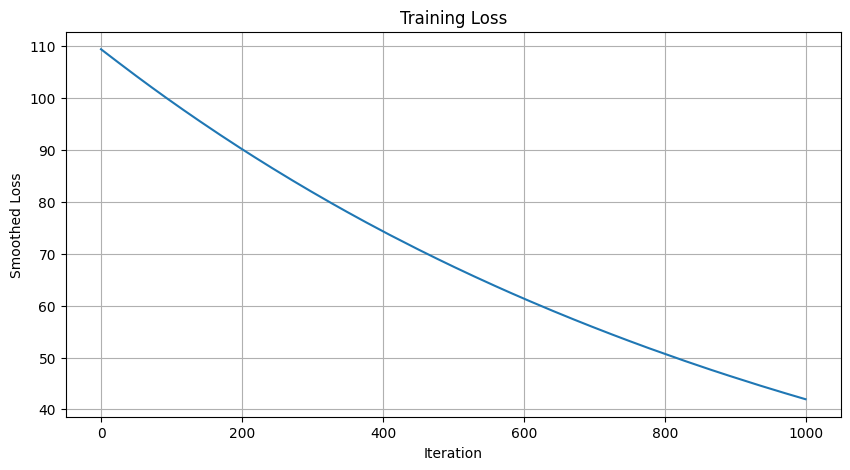

In [8]:
# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Smoothed Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

## 6. Text Generation from Trained Model

After training, we generate text again to see what patterns the model has learned.
The model should now produce text that resembles the training data in some way,
showing that it has learned the statistical patterns of character sequences in the book.

In [9]:
# Generate text from the trained model
h0 = np.zeros((m, 1))
x0 = np.zeros((K, 1))
x0[char_to_ind[book_data[0]], 0] = 1  # First character of the book

print("Generating text from trained model...")
trained_text, _ = model.synthesize_text(h0, x0, 200, ind_to_char, char_to_ind, rng=rng)
print(trained_text)

Generating text from trained model...
re thethe non pebe sore, siondynf rlleathedr, onettor mae wevee  ererrn;y the ehink. 
of tha.de"s andeco.  Mror thithe, holy Le lond the de fedpyor.
	 noumdFnlot eeth t, tnangisle berreronke thes addr


## 7. Experimenting with Different Sampling Strategies

### Theory: Sampling Strategies

The way we sample from the model's output distribution affects the generated text:

1. **Greedy sampling**: Always pick the most likely next character (deterministic)
   - Can get stuck in repetitive patterns

2. **Temperature sampling**: Adjust the "sharpness" of the probability distribution
   - T < 1: Makes the distribution more peaked (more conservative/deterministic)
   - T > 1: Makes the distribution more uniform (more diverse/random)
   - T = 1: Uses the raw model probabilities

3. **Nucleus (top-p) sampling**: Sample from the smallest set of characters whose cumulative probability exceeds a threshold
   - Controls diversity while maintaining coherence
   - Avoids extremely unlikely outputs

In [10]:
# Generate text with temperature sampling
print("Generating text with temperature sampling...")
for temperature in [0.2, 0.5, 1.0]:
    print(f"\nTemperature = {temperature}")
    temp_text, _ = model.synthesize_text(
        h0, x0, 200, ind_to_char, char_to_ind, 
        sampling_strategy='temperature', temperature=temperature, rng=rng
    )
    print(temp_text)

Generating text with temperature sampling...

Temperature = 0.2
e he the the he the he he the he the the the he he the the he the he the he the he the he the he the he he the the he the the he he the he he he the he he the the he he he he the he he the the he he t

Temperature = 0.5
k beehed He the rathen toe core he be tid wice he  he nor he the ine he he he corld he the pe in, ban der he he he he the told bo mtind mathe the the wild ane ha been the mor the far and the couge cre

Temperature = 1.0
Wrmong,nd oo tl....
	Herneed ag s, mond t eo wneer"ng- "'gored whe neen. .Y ohe hane was onwis lasc ud ire fler..
	"2m tle Ned hutiad  on tued he wowow neonle derogo theknoumbop nol n, loramead.P wird


In [11]:
# Generate text with nucleus sampling
print("Generating text with nucleus sampling...")
for theta in [0.5, 0.7, 0.9]:
    print(f"\nTheta = {theta}")
    nucleus_text, _ = model.synthesize_text(
        h0, x0, 200, ind_to_char, char_to_ind, 
        sampling_strategy='nucleus', theta=theta, rng=rng
    )
    print(nucleus_text)

Generating text with nucleus sampling...

Theta = 0.5
king the ha were told ared the ha s oure wan he hin the son hed the he the soided the the caide ce wild beer oret her ind ce his wane.. 	"ere he coll wone the  and an hed an bed an he cat ard wo ceed 

Theta = 0.7
toed ais bain tor wes ald he ald and war.. see inethe ha con nl be and cour.d an aroren bas. wan ile her seind cirim, toe bad cale colil the he mand han dot lo lldel s to hed he weod whe dile bong son

Theta = 0.9
breh. aighe ther faug yuther theme,.e whe  aal ho fored d cormed pring wo paldoemhes aas , an ipherer phed nimeid d suld wal,.
	FHal, ce coomdnasr io biace oled hhe ha wee hedore alt et and. thelad he


## 8. Full Training (Optional)

Now we'll train the model for a much larger number of iterations.
As training progresses, we should see:

1. The loss decreasing and stabilizing
2. Generated text becoming more and more coherent
3. The model learning character patterns, word structures, and eventually simple grammar

In [12]:
# Reinitialize the model
model = RNN(K, m, rng)

# Train for a larger number of iterations
num_updates = 100000
print(f"Training the model for {num_updates} iterations...")
loss_history, sample_texts, sample_iters = train_rnn(
    model, book_data, char_to_ind, ind_to_char, 
    seq_length=seq_length, eta=eta, num_updates=num_updates, rng=rng
)

Training the model for 100000 iterations...
Sample text at iteration 1:
^-Am}oz07g(uJ;zciCLnBNE9JIZ•;YphGXbTü6t	DzZB"}ybDY;,SK1YQfwüpO1tW/4YZ-•MeKyZIW6;6v(J•1!lidG
;CH!di	V:k0gkRyAVd•Tmw4ekd1XY904I}GliVW2jC
H_H2NE'0,(.sCEdD"2.Aa:HyZWYrV9cEvss
/fY0afzZsI)WüfwmRnfsjW;b	ec26

Sample text at iteration 1:
^-Am}oz07g(uJ;zciCLnBNE9JIZ•;YphGXbTü6t	DzZB"}ybDY;,SK1YQfwüpO1tW/4YZ-•MeKyZIW6;6v(J•1!lidG
;CH!di	V:k0gkRyAVd•Tmw4ekd1XY904I}GliVW2jC
H_H2NE'0,(.sCEdD"2.Aa:HyZWYrV9cEvss
/fY0afzZsI)WüfwmRnfsjW;b	ec26

iter = 100, smooth loss = 99.439723, time = 0.11s
iter = 200, smooth loss = 90.261180, time = 0.21s
iter = 300, smooth loss = 81.936725, time = 0.31s
iter = 400, smooth loss = 74.391911, time = 0.41s
iter = 500, smooth loss = 67.577158, time = 0.51s
iter = 600, smooth loss = 61.400471, time = 0.61s
iter = 700, smooth loss = 55.803467, time = 0.71s
iter = 800, smooth loss = 50.724052, time = 0.81s
iter = 900, smooth loss = 46.128805, time = 0.92s
iter = 1000, smooth loss = 41.970084, time = 1

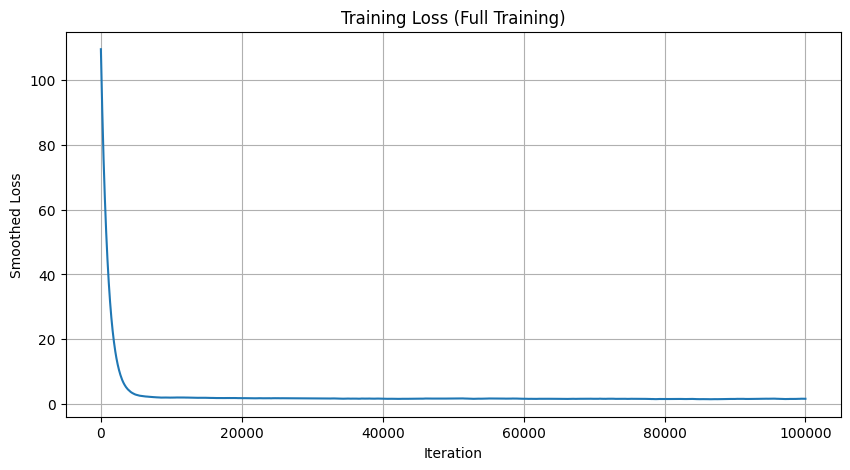

In [13]:
# Plot full loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Smoothed Loss')
plt.title('Training Loss (Full Training)')
plt.grid(True)
plt.show()

In [14]:
# Generate a longer sample from the fully trained model
h0 = np.zeros((m, 1))
x0 = np.zeros((K, 1))
x0[char_to_ind[book_data[0]], 0] = 1

print("Generating a 1000-character sample from the fully trained model...")
final_sample, _ = model.synthesize_text(h0, x0, 1000, ind_to_char, char_to_ind, rng=rng)
print(final_sample)

Generating a 1000-character sample from the fully trained model...
e on, Dooky again," said Mr. Weaslin, but but your stowing an stufl," said Rod in," said Dumbledore's students was nevely.
"Aho'l, and Harry, "sompirtion whoch, Ron, how, And Georted, gotweldly caured his fowr stown it, under coulled every derin-oy of woole naws.  "Mosling," said Molding a tould tore.  "Dumbledes wanding years openticalnd anxixcion lime her saviones not of who seemed it ispation who do that on a tapsed know last Hermury, Dust Dearlnes, Frose.  The coulsend whore fuets, and Geornes, are to prokentry chowers led retea know, anyon, eyes...  Do-blake incr. Goodars.  Ou and George ent.
"But' Genece innisemer ovey woodent to courch?  he roumentiniors to up," sain.
"What was anpotted.  "Don'mogs.
"Every you atturestence evan, puoder on eyes, and Aude is.  The threalp rutmins beched neem inting to George, unliads looking though it deen was a there.  "Pamansthay a tappes one pusncing them is is ears, wooking sto

## 9. Prepare Data for Report

Here we examine samples from different stages of training to observe the model's progression.

### Interpreting the Results:

The output shows samples from different training stages with their corresponding iteration number and loss value:

- **Early Training (iterations 1-5000)**: Text is mostly random characters with no real structure
- **Middle Training (iterations 10000-50000)**: 
  - Words begin to form
  - Basic sentence structure emerges
  - Character names appear
  - Still contains many errors and nonsensical sequences
- **Late Training (iterations 50000-100000)**:
  - More coherent sentences
  - Better grammar
  - Character dialogue with quotes
  - Recognizable narrative elements from Harry Potter

The loss decreases rapidly at first and then stabilizes, showing that the model becomes better at predicting the next character but has inherent limitations due to its size and architecture.

This progression illustrates how RNNs learn language from the character level up:
1. First learning character frequencies
2. Then common character combinations
3. Then word-like structures
4. Then simple grammar patterns
5. And finally, elements of the narrative style

In [15]:
# Print samples for the report
for i, (iteration, text) in enumerate(zip(sample_iters, sample_texts)):
    if i % 10 == 0 or i == 0:
        print(f"iter = {iteration}, smooth loss={loss_history[iteration-1]}")
        print(text)
        print()

iter = 1, smooth loss=109.44553596936932
^-Am}oz07g(uJ;zciCLnBNE9JIZ•;YphGXbTü6t	DzZB"}ybDY;,SK1YQfwüpO1tW/4YZ-•MeKyZIW6;6v(J•1!lidG
;CH!di	V:k0gkRyAVd•Tmw4ekd1XY904I}GliVW2jC
H_H2NE'0,(.sCEdD"2.Aa:HyZWYrV9cEvss
/fY0afzZsI)WüfwmRnfsjW;b	ec26

iter = 5000, smooth loss=2.8938249089332806
in deids at them," on then'e uriingr juppuriplirs?" Mry'sqeat, thaked shouple Is ardy thene eavisgudras, "nyayg neonve thiike the thet crouor of themulliscing ouvirniching wen, whald; of rraillacknte 

iter = 10000, smooth loss=2.0170646501161604
- om Did ly ow whe fas mats a cll?"
"Bugl wat doune fine Cung a dedla treng of to picined eia seur vartsef emaks ank ele,","
's Cometoly dobett," seaded ald acll treisly.  "Mr.  hibe E wreald shane in

iter = 15000, smooth loss=1.9477187656302413
, and as enone llay umbind the aoplling at ank ortininglf clumbledone of ag in beck fustureato tlle, Durthey and midl he pered deend to Harry doowdorno lilking of the raldys Cenk atp atris hem's.  Dom

iter = 20000, smo